In [1]:
import pandas as pd
import nltk
import numpy as np
import textrank
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import collections
from collections import defaultdict

In [2]:
import gensim

Using TensorFlow backend.


In [3]:
import pickle

In [4]:
col_labels = ['Date','AppID','AppName','Lang','1', '2', '3', 'Author','Stars','Title','Review','Reply','Device','DeviceType','Tags','Updated']

In [5]:
df = pd.read_csv('reviews_googleplay_1513852115.csv',  
                  skiprows=4, engine='python', names = col_labels, index_col=False,
                  error_bad_lines=True
                 )

In [7]:
df.head()

,Date,AppID,AppName,Lang,1,2,3,Author,Stars,Title,Review,Reply,Device,DeviceType,Tags,Updated
0,\t2017-12-21,com.wachanga.babycare,Baby Breastfeeding Tracker. Newborn Diary,es,NaN,NaN,NaN,Aser Moreiro,4,NaN,"Los primeros días y por la falta de sueño, cas...",NaN,NaN,NaN,NaN,NaN
1,\t2017-12-21,com.wachanga.babycare,Baby Breastfeeding Tracker. Newborn Diary,tr,NaN,NaN,NaN,Serra Bora,5,NaN,Verileri kaybet riskine karsi mail yada baska ...,NaN,NaN,NaN,NaN,NaN
2,\t2017-12-20,com.wachanga.babycare,Baby Breastfeeding Tracker. Newborn Diary,de,NaN,NaN,NaN,Kerstin Meitz,3,NaN,Im Prinzip ist die App ganz gut und erfüllt au...,NaN,NaN,NaN,NaN,NaN
3,\t2017-12-20,com.wachanga.babycare,Baby Breastfeeding Tracker. Newborn Diary,fr,NaN,NaN,NaN,Sonia Lamotte,5,NaN,J'ai l'impression qu'il y a un énorme beug dep...,NaN,NaN,NaN,NaN,1.0
4,\t2017-12-20,com.wachanga.babycare,Baby Breastfeeding Tracker. Newborn Diary,cs,NaN,NaN,NaN,NaN,4,NaN,"Super aplikace, ale docela by se jeste hodil p...",NaN,NaN,NaN,NaN,NaN


In [8]:
df_1 = df.drop(['AppID','AppName', '1', '2', '3', 'Device','DeviceType','Tags','Updated'], axis =1)

#col_labels = ['Date',,'Lang', 'Author','Stars','Title','Review','Reply',]

In [9]:
df_1.tail(3)

,Date,Lang,Author,Stars,Title,Review,Reply
4685,\t2015-07-08,ru,Связной Связной,3,NaN,Время после кормления и всего остального показ...,"Здравствуйте! Проверьте, пожалуйста, верный ли..."
4686,\t2015-07-07,ru,Maxim Kolpakov,5,Удобное приложение,"Жена кормит дочку, обязательно фиксируя в этом...",NaN
4687,\t2015-07-04,ru,Роман Муратов,5,NaN,Супруга довольна,Спасибо за отзыв!


In [10]:
df_1.shape

(4688, 7)

In [11]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4688 entries, 0 to 4687
Data columns (total 7 columns):
Date      4688 non-null object
Lang      4688 non-null object
Author    3914 non-null object
Stars     4688 non-null int64
Title     197 non-null object
Review    4687 non-null object
Reply     526 non-null object
dtypes: int64(1), object(6)
memory usage: 256.5+ KB


In [ ]:
#plt.plot(x)

In [12]:
x = df_1.groupby('Lang').Review.count().sort_values(ascending = False)
#sns.distplot(x)

In [13]:
x_Lang = pd.DataFrame(x)

In [15]:
x_Lang[0:15].style.bar()

,Review
Lang,
ru,1295
pt,972
es,521
de,477
en,446
fr,201
ko,148
pl,142
it,108


## загружаем подготовленный текст с переводом

In [501]:
with open('united_list_lower.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    united_list_lower = pickle.load(f)

In [502]:
len (total_list_lower)

3332

In [588]:
with open('united_list_fresh_lower.pickle', 'rb') as ff:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    united_list_fresh_lower = pickle.load(ff)

In [589]:
len (united_list_fresh_lower)

1031

In [590]:
total_list_lower = united_list_lower + united_list_fresh_lower

In [591]:
len(total_list_lower)

4363

## Создаем стоп словарь 

In [507]:
# формируем список стоп слова
import string
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize

### включаем пунктуацию 

In [508]:
punct = string.punctuation
punct

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [509]:
list_punct = [x for x in punct]

In [510]:
print (list_punct)

['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']


In [511]:
stop_words_f = set(stopwords.words('english'))
stop_words_f.update(list_punct)

In [512]:
len(stop_words_f)

185

### Добавляем в список стоп слов позитивные слова из словаря

In [ ]:
# загружаем сентименты из датафрейма -словаря 
# https://hlt-nlp.fbk.eu/technologies/sentiwords

In [513]:
df_sentiments = pd.read_pickle('df_sentiments.pkl')

In [514]:
df_sentiments.tail()

,lemma,PoS,prior_polarity_score
155282,zymolytic,a,-0.19821
155283,zymosis,n,0.15754
155284,zymotic,a,-0.08847
155285,zymurgy,n,0
155286,zyrian,n,0


In [515]:
df_sentiments['score'] = [float(x) for x in df_sentiments.prior_polarity_score]

In [516]:
df_sentiments.tail()

,lemma,PoS,prior_polarity_score,score
155282,zymolytic,a,-0.19821,-0.19821
155283,zymosis,n,0.15754,0.15754
155284,zymotic,a,-0.08847,-0.08847
155285,zymurgy,n,0,0.00000
155286,zyrian,n,0,0.00000


In [ ]:
## в словаре есть рейтинг у каждого слова prior_polarity_score. Посмотрим, как он оценивает по рейтингу слова,
#которые нам раньше выдавала модель 
# perfect 0.54757, useful 0.52504, convenient 0.53754, super 0.51256, easy 0.61758, excellent 	0.64003, 
#helpful 0.60754, satisfied 0.54009
# учитывая, что нам нужны более отриацтельные ключевые слова, мы поставим порог для ключевых слов - 0,3 

In [517]:
start_with = df_sentiments[df_sentiments.lemma.str.startswith('satisfied')]

In [518]:
start_with1 = df_sentiments[df_sentiments.lemma.str.startswith('problem')]

In [519]:
start_with1

,lemma,PoS,prior_polarity_score,score
110035,problem_solver,n,0,0.00000
110036,problem_solving,n,0,0.00000
110037,problem-oriented_language,n,0,0.00000
110038,problem,n,-0.37002,-0.37002
110039,problematic,a,-0.60501,-0.60501
110040,problematical,a,-0.10451,-0.10451
110041,problematically,r,0,0.00000


In [ ]:
# В среднем, prior_polarity_score у позитивных слов составляет 0.5. Это будет порогом для ключевых слов в нашем списке стоп слов

### добавляем в список стоп слов все слова, у которых рейтинг равен или выше 0,5

In [520]:
df_sentiments_0_5 = df_sentiments[(df_sentiments['score'] > -0.3)]

In [521]:
df_sentiments_0_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147388 entries, 0 to 155286
Data columns (total 4 columns):
lemma                   147388 non-null object
PoS                     147388 non-null object
prior_polarity_score    147388 non-null object
score                   147388 non-null float64
dtypes: float64(1), object(3)
memory usage: 5.6+ MB


In [523]:
positive_words = [x for x in df_sentiments_0_5.lemma]

In [525]:
len(positive_words)

147388

In [526]:
## обновляем список стоп слов

In [527]:
stop_words_f.update(positive_words)

In [528]:
len(stop_words_f)

140412

In [ ]:
## по результам работы модели, имеет смысл добавить список наиоболее частотных слов, которые характерны для этих отзывов

In [669]:
typical_words = ["everything","app","lot", "application", 'breastfeeding', 'breast-feeding', 'apps']

In [670]:
stop_words_f.update(typical_words)

## Создаем список ключевых слов используя алгоритм textrank 

In [634]:
# находим ключевые слова через алгоритм textrank, ставим ограничения по кол-ву 35 и ссодержанию больше 0
united_list_good = [] #список отзывов, длины которых более 35 символов 
key_phrases = []
for i in total_list_lower:
    y = [b for b in textrank.extract_key_phrases(i) if b not in stop_words_f and not any(w in stop_words_f for w in b.split()) ] # вытаскиваем ключевые слова 
    if len(i) > 35 and len(y) > 0:
        key_phrases.append(y)
        united_list_good.append(i)

/Users/OzzyPeople/anaconda/lib/python3.6/site-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node super
  warnings.warn('zero out-degree for node %s' % u)


In [ ]:
# Сохраняем данные на диске в формате python списка 

In [716]:
with open('key_phrases.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(key_phrases, f, pickle.HIGHEST_PROTOCOL)

In [717]:
with open('key_phrases.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    key_phrases = pickle.load(f)

## Эксперимент 1 Text Rank

##  Векторизация 

In [635]:
import sklearn.feature_extraction.text
vctr = sklearn.feature_extraction.text.CountVectorizer(tokenizer = lambda key_phrases: key_phrases, preprocessor=lambda key_phrases: key_phrases)

# tokenizer = lambda key_phrases: key_phrases - должен взять список и отдать список 
#(вместо взять сплошной текст и отдать список слов)
# preprocessor=lambda x: x - должен взять список и отдать список

In [636]:
X_train = vctr.fit_transform(key_phrases) # скармливаем весь текст ключевых слов 

In [637]:
# 1965 - количество текстов в которых встречается 1464 ключевых слова в разных комбинациях 
X_train.shape

(587, 447)

## Кластеризация 

In [638]:
from sklearn.cluster import KMeans

In [537]:
# Выбираем оптимальное кол-во кластеров 

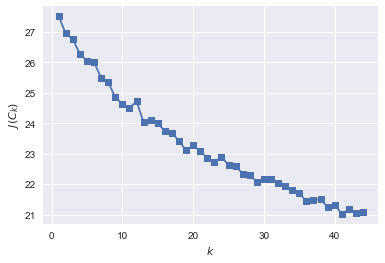

In [639]:
inertia = []
for k in range(1, 45):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X_train)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 45), inertia, marker='s');
plt.xlabel('$k$') # количество кластеров 
plt.ylabel('$J(C_k)$'); # среднее расстояние до центроидов 

In [640]:
n_clusters_0 = 35

In [641]:
clf_kmeans0 = KMeans(n_clusters=n_clusters_0) #создается необученный кластеризатор 

In [602]:
# Передаем в модель все данные 

In [642]:
clusters_kmeans_predict0 = clf_kmeans0.fit_predict(X_train)
## чем отличается фит от предикт - делает фит (обучает модель) и предсказывает

In [643]:
clusters_kmeans_predict0.shape

(587,)

In [644]:
clusters_kmeans0 = clf_kmeans0.fit(X_train) # фит обучает кластеризатор 

In [ ]:
# центроид - среднее значение расстояний в одном классе 
# разница - между центроидом и длиной расстояний - это классифицировать по уменьшению 

## Оценка кластеров

In [645]:
# Создаем словарь - номер кластера это ключ, а значение - это текст (отзыв), который соответствует кластеру 
dict_c0 = defaultdict(list) 

# Создаем словарь - номер кластера это ключ, а значение - это список ключевых слов каждого отзыв, который соответствует кластеру 
dict_kp0 = defaultdict(list)


for i, elem in enumerate(clusters_kmeans_predict0):
    dict_c0[elem].append(united_list_good[i])
    dict_kp0[elem].append(key_phrases[i])

In [646]:
len(dict_c0)

35

In [647]:
len(dict_kp0)

35

In [652]:
dict_kp0_0 = dict_kp0[0]

### Определим топ N близких ключевых слов к центроидам
### чтобы вывести наиболее характерные слова для каждого кластера

In [654]:
# находим центроиды - это среднее значение всех точек в кластере
centroids0 = clusters_kmeans0.cluster_centers_

In [655]:
type (clusters_kmeans0)

sklearn.cluster.k_means_.KMeans

In [656]:
centroids0.shape

(35, 447)

In [657]:
from sklearn.metrics.pairwise import euclidean_distances

In [658]:
# находим среднее расстояние до центроида от каждой точки (ключевого слова из тренировачных данных)
dist_center_0 = euclidean_distances(centroids0, X_train)

In [659]:
dict_clust_keywords_0 = {} # номер кластера и список его индексов 
dict_clust_index_0 = {} # номер кластера и список ключевых слов 
n_words = 5 # количество наиболее близких слова
for i in range (n_clusters_0):
    dict_clust_index_0[i] = dist_center_0[i].argsort()[:n_words].tolist()
for b, k in dict_clust_index_0.items():
    dict_clust_keywords_0[b] = []
    for c in k:
        dict_clust_keywords_0[b].extend(key_phrases[c])
    dict_clust_keywords_0[b] = list(set(dict_clust_keywords_0[b]))

In [701]:
len(dict_clust_keywords_0[0])

2

In [660]:
dist_center_0.shape

(35, 587)

## Представим данные в виде таблички dataframe

In [661]:
columns_df_rank_kw = ['volume','keywords']

In [662]:
df_rank_kw = pd.DataFrame(index = dict_clust_keywords_0.keys(), columns=columns_df_rank_kw)

In [663]:
df_rank_kw['volume'] = [(len(dict_c0[i])) for i in sorted(dict_c0, reverse=False)] # кол-во текстов 

In [664]:
df_rank_kw['keywords'] = [', '.join(k) for i, k in sorted (dict_clust_keywords_0.items(), reverse=False)] # топ 5 пересекающихся ключевых слов

In [665]:
df_rank_kw['texts'] = ['| '.join(k) for i, k in sorted(dict_c0.items(),reverse=False) ]

In [666]:
df_rank_kw['textsvol'] = [sum(len(elem) for elem in k) for i, k in sorted(dict_c0.items(),reverse=False)]

In [667]:
df_rank_kw['avetext'] = round(df_rank_kw['textsvol'] / df_rank_kw['volume'])

In [668]:
df_rank_kw

,volume,keywords,texts,textsvol,avetext
0,334,"forget, error","like the app, as an inexperienced mother i alw...",64526,193.0
1,3,diaper,"thanks for the app. like everything, but to me...",433,144.0
2,8,"deprivation, complaint, annoyance, facebook",use the application for the third month. like....,2466,308.0
3,12,"hospital, 😁🍼👍, syncronisation, panaloc, downlo...","the app is good, all very much. conveniently f...",2167,181.0
4,28,"confused, 'bottle",downloaded when the baby was almost a month. v...,8342,298.0
5,7,everyone,"great app, before i tried to record, but it wa...",1997,285.0
6,18,operation,"good app, easy-to-use and absolutely free. i w...",1874,104.0
7,15,medication,put 5! considered almost everything in the app...,4230,282.0
8,27,anything,"all well and good, but there is one real minus...",7406,274.0
9,16,"something, graciasss",really like the app. use from the birth of the...,3954,247.0


In [569]:
df_rank_kw.texts[39]

'very good app, just would it it supplement on the par trivia - eg. in prebalovani could be the pick, whether it was diaper jednorazova or latkova, could be available even the daily chart and i could be a better job with the charts and record podanych leku or but temperature could be seen in the time-axis. so maybe in the future 😉. but otherwise i am satisfied 😀'

## найдем похожие слова между ключевыми словами, чтобы объединить кластеры

https://rare-technologies.com/word2vec-tutorial/

In [237]:
import word2vec

In [677]:
with open('total_review_apps_eng_lower.pickle', 'rb') as d:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    total_review_apps_eng_lower = pickle.load(d)

In [679]:
tt = total_review_apps_eng_lower + total_list_lower

In [680]:
len(tt)

8432

In [683]:
# import modules & set up logging
import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
 
sentences = [x.split(" ") for x in tt]

# передать все тексты для тренировки 
# потом можно 

# train word2vec on the two sentences
model = gensim.models.Word2Vec(sentences, min_count=3) # можно увеличить 2 - только 

2017-12-22 00:21:09,331 : INFO : collecting all words and their counts
2017-12-22 00:21:09,332 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-12-22 00:21:09,389 : INFO : collected 8519 word types from a corpus of 209891 raw words and 8432 sentences
2017-12-22 00:21:09,390 : INFO : Loading a fresh vocabulary
2017-12-22 00:21:09,408 : INFO : min_count=3 retains 2814 unique words (33% of original 8519, drops 5705)
2017-12-22 00:21:09,410 : INFO : min_count=3 leaves 203187 word corpus (96% of original 209891, drops 6704)
2017-12-22 00:21:09,440 : INFO : deleting the raw counts dictionary of 8519 items
2017-12-22 00:21:09,441 : INFO : sample=0.001 downsamples 58 most-common words
2017-12-22 00:21:09,442 : INFO : downsampling leaves estimated 139853 word corpus (68.8% of prior 203187)
2017-12-22 00:21:09,444 : INFO : estimated required memory for 2814 words and 100 dimensions: 3658200 bytes
2017-12-22 00:21:09,456 : INFO : resetting layer weights
2017-12-22 0

In [684]:
model.wv.vocab

{'this': <gensim.models.keyedvectors.Vocab at 0x12a169518>,
 'is': <gensim.models.keyedvectors.Vocab at 0x12a169588>,
 'not': <gensim.models.keyedvectors.Vocab at 0x12a1696a0>,
 'a': <gensim.models.keyedvectors.Vocab at 0x12a169630>,
 'game': <gensim.models.keyedvectors.Vocab at 0x12a1696d8>,
 'but': <gensim.models.keyedvectors.Vocab at 0x12a169668>,
 'of': <gensim.models.keyedvectors.Vocab at 0x12a169780>,
 'uncomfortable': <gensim.models.keyedvectors.Vocab at 0x12a1697b8>,
 'advertising': <gensim.models.keyedvectors.Vocab at 0x12a169828>,
 'and': <gensim.models.keyedvectors.Vocab at 0x12a169860>,
 'so': <gensim.models.keyedvectors.Vocab at 0x12a169898>,
 'that': <gensim.models.keyedvectors.Vocab at 0x12a1698d0>,
 'it': <gensim.models.keyedvectors.Vocab at 0x12a169908>,
 'possible': <gensim.models.keyedvectors.Vocab at 0x12a169940>,
 'to': <gensim.models.keyedvectors.Vocab at 0x12a169978>,
 '': <gensim.models.keyedvectors.Vocab at 0x12a1699b0>,
 'the': <gensim.models.keyedvectors.Voca

In [351]:
model['feeding']

array([-0.50300199,  0.04139743,  0.82454377,  0.41891226, -1.084885  ,
       -0.03003933,  0.07874607,  0.48014137, -0.66366529,  1.68105388,
       -0.37871256, -1.04211962,  0.76086456, -0.38564274, -0.59853166,
       -0.04918139, -0.06593145, -0.80067343, -0.06981833,  1.11383295,
        0.19199596,  0.95754868, -0.43977851,  0.14806251, -0.42141971,
       -0.30786735,  0.14245957,  0.310857  , -0.39109266,  0.5427863 ,
        0.15948354,  0.30500302, -0.47283986,  0.08327557, -0.10890892,
        0.29025045,  0.30813718,  0.26249543,  1.0311501 ,  0.25586045,
       -0.05494288, -0.82644272, -0.22721148,  0.89808345, -0.91322565,
       -0.72104716, -0.35385534, -0.15113999,  0.43976849,  0.0560342 ,
        0.50092983,  1.05972099, -0.72786349,  0.6489411 , -0.13758892,
       -0.58362192, -0.3875894 , -0.55948311, -0.04484276, -0.11134632,
       -0.0438694 , -0.08521074, -0.60830629, -0.64786792, -0.18130584,
        0.2429572 , -0.19910438,  0.28942937,  0.23924834, -0.49

In [82]:
#model0 = gensim.models.KeyedVectors.load_word2vec_format('key_phrases', binary=False)
# численный словарь синонимов из гугла 

In [685]:
model.most_similar('feeding')

2017-12-22 00:21:25,196 : INFO : precomputing L2-norms of word weight vectors


[('sleep', 0.9394545555114746),
 ('time', 0.9305657744407654),
 ('last', 0.9158550500869751),
 ('waking', 0.9151004552841187),
 ('breast', 0.9084455966949463),
 ('day', 0.8818502426147461),
 ('chest,', 0.8813436031341553),
 ('registered', 0.8661786317825317),
 ('hours', 0.863349437713623),
 ('feeding,', 0.8467268943786621)]

In [687]:
model.wv.similarity('feeding', 'son')

0.59415472176442974

In [703]:
## Считаем по всем кластерами среднюю схожесть все ключевых слов внутри кластера по отношению ко всем ключевым словам 
## из других кластеров. так как у как у нас 35 кластеров, получается, 1225 пар

d_par = {}

for i in range (n_clusters_0):
    for g in range (n_clusters_0):
        d_par[(i,g)] = 0.0
        n = 0  # сколько раз мы просуммировали, так как в модели может и не быть ключевого слова 
        if i == g:
            continue
        for k in df_rank_kw.keywords[i]:
            for j in df_rank_kw.keywords[g]:
                if j in model.wv.vocab and k in model.wv.vocab:
                    d_par[(i,g)] += model.wv.similarity(k, j)
                    n+=1
        if n > 0:
            d_par[(i,g)] =  d_par[(i,g)] / n

In [704]:
len(d_par)

1225

In [715]:
for i, k in d_par.items():
    if k > 0.8:
        print (i, df_rank_kw.keywords[i[0]], df_rank_kw.keywords[i[1]])

(0, 5) forget, error everyone
(5, 0) everyone forget, error
(5, 10) everyone problem
(5, 19) everyone forgetful
(10, 5) problem everyone
(10, 19) problem forgetful
(19, 5) forgetful everyone
(19, 10) forgetful problem


## Эксперимент 2 TF - IDF без выделения ключевых слов RANK 

In [718]:
import sklearn.feature_extraction.text
vctr1 = sklearn.feature_extraction.text.CountVectorizer()

In [719]:
X_train1 = vctr1.fit_transform(united_list_good) # векторизируем весь текст - преобразованные тексты 
#на основе векторизатоа
# берем все тексты и ищем уникальные слова
# В итоге, vctr1 - обученный векторизатор, X_train1 - это тексты (элементы) в виде точек в пространстве

In [552]:
# vctr1.vocabulary_ 

In [720]:
X_train1.shape

(587, 2566)

In [721]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [722]:
tfidf = TfidfVectorizer(stop_words=stop_words_f) 

In [723]:
from sklearn.feature_extraction.text import TfidfTransformer

In [724]:
tfidf_transformer = TfidfTransformer()

In [725]:
X_train1_tfidf = tfidf_transformer.fit_transform(X_train1)

In [726]:
X_train1_tfidf.shape

(587, 2566)

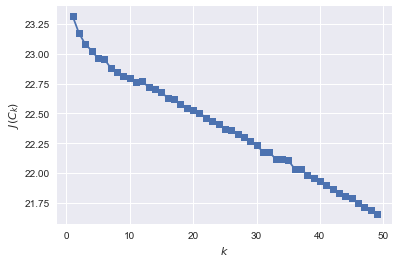

In [727]:
inertia1 = []
for k in range(1, 50):
    kmeans1 = KMeans(n_clusters=k, random_state=1).fit(X_train1_tfidf)
    inertia1.append(np.sqrt(kmeans1.inertia_))

plt.plot(range(1, 50), inertia1, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [728]:
n_clusters_1 = 45

In [729]:
clf_kmeans1 = KMeans(n_clusters=n_clusters_1)

In [730]:
clusters_kmeans_predict1 = clf_kmeans1.fit_predict(X_train1_tfidf)

In [731]:
clusters_kmeans1 = clf_kmeans1.fit(X_train1_tfidf) # фит обучает кластеризатор 

## Анализируем кластеры по текстам 

In [732]:
# находим центроиды - это среднее значение всех точек в кластере
centroids1 = clusters_kmeans1.cluster_centers_

In [733]:
# находим расстояние от центроида до каждой точки (отзыва)
dist_center_1 = euclidean_distances(centroids1, X_train1_tfidf)

In [734]:
# словарь всех текстов по кластерам
dict_c1 = defaultdict(list)
for i, elem in enumerate(clusters_kmeans_predict1):
    dict_c1[elem].append(united_list_good[i])

In [735]:
dict_clust_texts_1 = defaultdict(list) # номер кластера и список наиболее близких индексов текстов
dict_clust_index_1 = {} # номер кластера и список отзывов 

n_texts = 3 # количество наиболее близких текстов

for i in range (n_clusters_1):
    dict_clust_index_1[i] = dist_center_1[i].argsort()[:n_texts].tolist()

for b, k in dict_clust_index_1.items(): #b - номер кластера, k - список индексов 
    for c in k: # c - каждый индекс в кластере b из списка k
        dict_clust_texts_1[b].append(united_list_good[c])

## Представим данные в виде таблички dataframe

In [736]:
columns_df_tfidf = ['volume','keytexts']

In [737]:
df_tfidf = pd.DataFrame(index = dict_clust_texts_1.keys(), columns=columns_df_tfidf)

In [738]:
df_tfidf['volume'] = [(len(dict_c1[i])) for i in sorted(dict_c1, reverse=False)] # кол-во текстов 

In [739]:
df_tfidf['keytexts'] = [', '.join(k) for i, k in sorted (dict_clust_texts_1.items(), reverse=False)] # топ 5 пересекающихся ключевых слов

In [740]:
df_tfidf['texts'] = ['| '.join(k) for i, k in sorted(dict_c1.items(),reverse=False) ]

In [741]:
df_tfidf['textsvol'] = [sum(len(elem) for elem in k) for i, k in sorted(dict_c1.items(),reverse=False)]

In [742]:
df_tfidf['avetext'] = round(df_tfidf['textsvol'] / df_tfidf['volume'])

In [743]:
df_tfidf

,volume,keytexts,texts,textsvol,avetext
0,3,easy-handling. meaningful evaluations. everyth...,"all that is described there, but still have no...",290,97.0
1,35,very good. you have the options to mark the ti...,"in shock!great app, very helpful. would be 5* ...",6216,178.0
2,16,after upgrading somehow flies feeding timer/sl...,"very good to keep all of the drinks; sleep, fe...",1990,124.0
3,8,"class app. i am very satisfied. easy to use, y...","the app is very good, very convenient! whateve...",1703,213.0
4,13,helps me keep track of last diaper and last fe...,recommend. of the minuses - there is no author...,2757,212.0
5,13,this app makes life with a newborn easier. the...,like the app. but not very useful when timing ...,3589,276.0
6,9,"i like just need to add the bathroom time, som...","very handy app, you can delete , edit,change d...",1625,181.0
7,106,"hello,very good app,easy to use and convenient...","the app is user friendly, everything you need ...",35990,340.0
8,24,the app is very nice and comfortable. but it i...,"all well and good, but there is one real minus...",5653,236.0
9,5,easy to use. i use it to track feedings and di...,great mom of the first trip helped a lot can🙏|...,528,106.0


In [1]:
df_tfidf[0:5]

NameError: name 'df_tfidf' is not defined

In [744]:
df_tfidf.keytexts[0]

'easy-handling. meaningful evaluations. everything top!, easy operation, simple menu and everything is available what do i need! top, very clear handling-designed and very simple. perfect for me :)'

## Эксперимент номер 3 - Rake

In [745]:
import rake_nltk

In [812]:
def extract_keywords_from_text(text, min_score):
    r = rake_nltk.Rake(language='english')
    r.extract_keywords_from_text(text)
    return  [word[1] for word in r.get_ranked_phrases_with_scores() if word[0] >= min_score or min_score is None]
# если нет score нет, то он не учитывается
# word[1] - это уже ключевое слова, а word[0] - это рейтинг 

In [813]:
# находим ключевые слова через алгоритм textrank, ставим ограничения по кол-ву 35 и ссодержанию больше 0
# выделить текст и ставим score 3 как показатель 

united_total_list_rake = []
key_phrases_rake = []
for i in united_list_lower:
    y = [b for b in extract_keywords_from_text(i, 3) if b not in stop_words_f]
    if len(i) > 35 and len(y) > 0: 
        key_phrases_rake.append(y)
        united_total_list_rake.append(i)

In [814]:
len(united_total_list_rake)

1766

In [815]:
len(key_phrases_rake)

1766

In [ ]:
# Сохраняем данные на диске в формате python списка 

In [299]:
with open('key_phrases_rake.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(key_phrases_rake, f, pickle.HIGHEST_PROTOCOL)

In [799]:
with open('key_phrases_rake.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    key_phrases_rake = pickle.load(f)

In [ ]:
# Сохраняем данные на диске в формате python списка 

In [300]:
with open('united_total_list_rake.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(united_total_list_rake, f, pickle.HIGHEST_PROTOCOL)

In [800]:
with open('key_phrases_rake.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    key_phrases_rake = pickle.load(f)

## Векторизируем 

In [816]:
import sklearn.feature_extraction.text
vctr2 = sklearn.feature_extraction.text.CountVectorizer(tokenizer = lambda key_phrases_rake: key_phrases_rake, preprocessor=lambda key_phrases_rake: key_phrases_rake)

# tokenizer = lambda key_phrases: key_phrases - должен взять список и отдать список 
#(вместо взять сплошной текст и отдать список слов)
# preprocessor=lambda x: x - должен взять список и отдать список

In [817]:
X_train2 = vctr2.fit_transform(key_phrases_rake) # скармливаем весь текст ключевых слов 

In [818]:
X_train2.shape

(1766, 4103)

## Кластеризация 

In [819]:
from sklearn.cluster import KMeans

In [820]:
# Выбираем оптимальное кол-во кластеров 

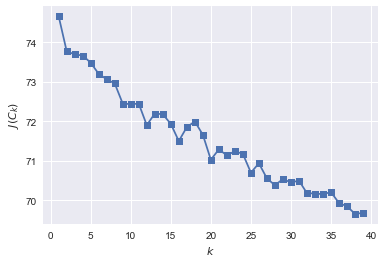

In [821]:
inertia2 = []
for k in range(1, 40):
    kmeans2 = KMeans(n_clusters=k, random_state=1).fit(X_train2)
    inertia2.append(np.sqrt(kmeans2.inertia_))

plt.plot(range(1, 40), inertia2, marker='s');
plt.xlabel('$k$') # количество кластеров 
plt.ylabel('$J(C_k)$'); # среднее расстояние до центроидов 


# интуитивно по графику видно, что он скачет - неравномерный, нет седловой точки 
# ситуаиция не стабилизируется 

In [822]:
n_clusters_2 = 35

In [823]:
clf_kmeans2 = KMeans(n_clusters=n_clusters_2) #создается необученный кластеризатор 

In [674]:
# Передаем в модель все данные 

In [824]:
clusters_kmeans_predict2 = clf_kmeans2.fit_predict(X_train2)
## чем отличается фит от предикт - делает фит (обучает модель) и предсказывает

In [825]:
clusters_kmeans_predict2.shape

(1766,)

In [826]:
clusters_kmeans2 = clf_kmeans2.fit(X_train2) # фит обучает кластеризатор 

## Оценка кластеров

In [827]:
# Создаем словарь - номер кластера это ключ, а значение - это текст (отзыв), который соответствует кластеру 
dict_c2 = defaultdict(list)

# Создаем словарь - номер кластера это ключ, а значение - это список ключевых слов каждого отзыв, который соответствует кластеру 
dict_kp2 = defaultdict(list)


for i, elem in enumerate(clusters_kmeans_predict2):
    dict_c2[elem].append(united_total_list_rake[i])
    dict_kp2[elem].append(key_phrases_rake[i])

### Определим топ N близких ключевых слов к центроидам
### чтобы вывести наиболее характерные слова для каждого кластера

In [828]:
# находим центроиды - это среднее значение всех точек в кластере
centroids2 = clusters_kmeans2.cluster_centers_

In [829]:
centroids2.shape

(35, 4103)

In [830]:
# находим среднее расстояние до центроида от каждой точки (ключевого слова из тренировачных данных)
dist_center_2 = euclidean_distances(centroids2, X_train2)

In [831]:
dist_center_2.shape

(35, 1766)

In [832]:
dict_clust_keywords_2 = {} # номер кластера и список его индексов 
dict_clust_index_2 = {} # номер кластера и список ключевых слов 
n_words = 10 # количество наиболее близких слова
for i in range (n_clusters_2):
    dict_clust_index_2[i] = dist_center_2[i].argsort()[:n_words].tolist()
for b, k in dict_clust_index_2.items():
    for c in k:
        dict_clust_keywords_2[b] = key_phrases_rake[c]

## Представим данные в виде таблички dataframe

In [833]:
columns_df_rake = ['volume','keywords']

In [834]:
df_rake = pd.DataFrame(index = dict_clust_keywords_2.keys(), columns=columns_df_rake)

In [835]:
df_rake['volume'] = [(len(dict_c2[i])) for i in sorted(dict_c2, reverse=False)] # кол-во текстов 

In [836]:
df_rake['keywords'] = [', '.join(k) for i, k in sorted (dict_clust_keywords_2.items(), reverse=False)] # топ 5 пересекающихся ключевых слов

In [837]:
df_rake['texts'] = ['| '.join(k) for i, k in sorted(dict_c2.items(),reverse=False) ]

In [838]:
df_rake['textsvol'] = [sum(len(elem) for elem in k) for i, k in sorted(dict_c2.items(),reverse=False)]

In [839]:
df_rake['avetext'] = round(df_rake['textsvol'] / df_rake['volume'])

In [840]:
df_rake

,volume,keywords,texts,textsvol,avetext
0,1338,q want,thank you so much for your work! this is the b...,174907,131.0
1,2,keeping track,"statistics a little poorly labeled, but always...",164,82.0
2,60,"temperature chart, good app",i would like to decrypt in the charts clicking...,14288,238.0
3,1,track feedings,this app is so easy to use and the graphs are ...,386,386.0
4,2,keep track,"the app shows a lot of detail and reminds us, ...",250,125.0
5,1,"many possibilities, good app","in a word, great practice feeding time at inte...",242,242.0
6,60,great app,good app but sometimes shows incorrect statist...,11419,190.0
7,1,great sense,"the mode of the day shows is not correct, shif...",463,463.0
8,1,great app,"very good, but would need to improve the graph...",269,269.0
9,1,application efficient,put 5 stars instead of 4. at the moment this a...,304,304.0
